In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import my utils module. Need my `mse_func`
sys.path.append("../../../bin/")
from utils import *

# plotting templates
sns.set(context="talk", style="ticks") 
sns.set_palette("tab10")

#### Configs

In [2]:
stem="/net/noble/vol2/home/lincolnh/code/2023_harris_deep_impute/results/2024-02-20_dream_compare/ensemble-normalized/data/"
train_tail="_train_dreamAI.csv"
test_tail="_test_dreamAI.csv"

cohorts=["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
         "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]

# The random generator, for Gaussian sample impute
rng = np.random.default_rng(18)

#### Functions

In [3]:
def mean_impute(train_set, test_set):
    """
    Take the row mean and return the reconstructed error. 
    Relies on the `mse_func` defined in our utils module. 
    
    Parameters
    ----------
    train_set, test_set : np.ndarray, 
        The train and test sets, respectively. 
    
    Returns
    ----------
    rm_test_error : float, 
        The row mean imputed test error. 
    """
    rm_imputed = train_set.copy()

    # Get the row means
    row_means = np.nanmean(rm_imputed, axis=1)

    # Get the indices that contain NaNs
    nan_idxs = np.where(np.isnan(rm_imputed))

    # Replace the NaNs with their corresponding row means
    for x, y in zip(nan_idxs[0], nan_idxs[1]):
        row_mean = row_means[x]
        rm_imputed[x,y] = row_mean

    # Get the test error
    rm_test_error = mse_func(rm_imputed, test_set)
    return rm_test_error
    
def min_impute(train_set, test_set):
    """
    Take the minimum value of each column, replace
    missing values with this, return the reconstruction
    error. Relies on the `mse_func` defined in our utils 
    module. 
    
    Parameters
    ----------
    train_set, test_set : np.ndarray, 
        The train and test sets, respectively.
    
    Returns
    -----------
    cm_test_error : float, 
        The col min imputed test error. 
    """
    cm_imputed = train_set.copy()

    # Get the column mins
    col_mins = np.nanmin(cm_imputed, axis=0)

    # Get the indices that contain NaNs
    nan_idxs = np.where(np.isnan(cm_imputed))

    # Replace the NaNs with their corresponding col mins
    for x, y in zip(nan_idxs[0], nan_idxs[1]):
        col_min = col_mins[y]
        cm_imputed[x,y] = col_min

    # Get the test error
    cm_test_error = mse_func(cm_imputed, test_set)
    return cm_test_error

def random_draw_impute(vec):
    """
    Imputes for a single *column* at a time using the Gaussian
    random draw procedure. This closely resembles the Perseus
    procedure described here: 
    https://cox-labs.github.io/coxdocs/replacemissingfromgaussian.html
    
    Parameters
    ----------
    vec : np.array, 
        A 1D vector, that is, column from the matrix
        to be imputed. 

    Returns
    ----------
    vec_recon : np.array, 
        The imputed vector
    """
    width_param=0.3
    downshift_param=1.8
    #print(len(vec))
    
    # Get the means and std
    v_mean = np.nanmean(vec)
    v_std = np.nanstd(vec)
    
    # Get the locations of the MVs
    nans = np.isnan(vec)
    vec_recon = vec.copy()
    
    # How many total MVs? 
    n_mv = np.count_nonzero(nans)
    
    center = v_mean - (v_std * 1.8)

    # Replace missing values with random draws
    vec_recon[nans] = rng.normal(
                        loc=center,
                        scale=v_std*width_param,
                        size=n_mv
    )
    # Make sure we don't have any negative values
    vec_recon = np.abs(vec_recon)
    
    return vec_recon

#### Init a dataframe to hold the results

In [4]:
bench_res = pd.DataFrame(columns=["cohort", "dream_error", "lupine_error"])
bench_res["cohort"] = ["BRCA", "CCRCC", "COAD", "GBM", "HGSC", 
                 "HNSCC", "LSCC", "LUAD", "PDAC", "UCEC"]
bench_res["dream_error"] = [0.039, 0.07, 0.04, 0.045, 0.065, 
                            0.065, 0.037, 0.045, 0.033, 0.055]
bench_res["lupine_error"] = [0.036, 0.047, 0.033, 0.039, 0.053, 
                             0.048, 0.032, 0.036, 0.03, 0.046]

---
## Add in baseline impute method
A side-by-side scatterplot might be the best way to go here. 
BRCA is fucked up for some reason. 

In [5]:
baseline_res = []

for cohort in cohorts:
    train_mat = pd.read_csv(stem + cohort + train_tail, index_col=0)
    test_mat = pd.read_csv(stem + cohort + test_tail, index_col=0)

    train = np.array(train_mat)
    test = np.array(test_mat)

    #mean_res = mean_impute(train, test)
    #min_res = min_impute(train, test)

    # Impute with Gaussian random sample
    # axis=0 will apply the impute function to every column 
    rd_imputed = np.apply_along_axis(random_draw_impute, 0, train)

    # Compute the test error for Gaussian random sample
    rd_error = mse_func(rd_imputed, test)

    curr_res = {
        "cohort": cohort, 
        "rand_draw_err": rd_error, 
    }
    baseline_res.append(curr_res)
    
baseline_res = pd.DataFrame.from_dict(baseline_res)

#### Add the baseline errors to the existing results dataframe

In [6]:
# bench_res["mean_error"] = baseline_res["mean_error"]
# bench_res["min_error"] = baseline_res["min_res"]
bench_res["rand_draw_error"] = baseline_res["rand_draw_err"]

#### Side-by-side scatterplot

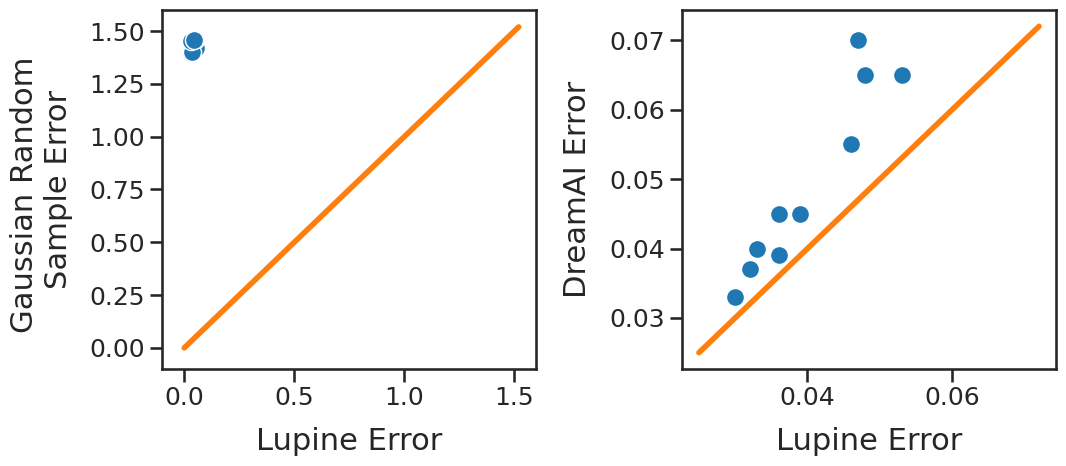

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))

# LUPINE VS MEAN IMPUTE
sns.scatterplot(
    data=bench_res, 
    x="lupine_error", 
    y="rand_draw_error", 
    alpha=1.0, 
    zorder=2, 
    s=170,
    ax=ax1,
)
#ax1.set_title()
ax1.set_xlabel("Lupine Error", labelpad=12, fontsize=22)
ax1.set_ylabel("Gaussian Random \nSample Error", labelpad=12, fontsize=22)

# Add diagonal line
ax1_min = 0.0
ax1_max = 1.52
x = np.linspace(ax1_min, ax1_max, 100)
y = x
ax1.plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

ax1.set_xlim(-0.1, 1.6)
ax1.set_ylim(-0.1, 1.6)

# LUPINE VS DREAM-AI
sns.scatterplot(
    data=bench_res, 
    x="lupine_error", 
    y="dream_error", 
    alpha=1.0, 
    zorder=2, 
    s=170,
    ax=ax2
)
#ax2.set_title()
ax2.set_xlabel("Lupine Error", labelpad=12, fontsize=22)
ax2.set_ylabel("DreamAI Error", labelpad=12, fontsize=22)

# Add diagonal line
ax2_min = 0.025
ax2_max = 0.072
x = np.linspace(ax2_min, ax2_max, 100)
y = x
ax2.plot(x, y, color="#ff7f0e", alpha=1.0, zorder=1, linewidth=4)

# ax1.minorticks_off()
# ax2.minorticks_off()

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

#ax1.xaxis.set_ticks(np.arange(0.02, 0.16, 0.04))
#ax1.yaxis.set_ticks(np.arange(0.02, 0.16, 0.04))

fig.tight_layout()

plt.show()
#plt.savefig("../figures/mse-benchmarking-figure-v2.pdf", bbox_inches="tight")

#### What if we changed up the axes? 
I think this looks great!

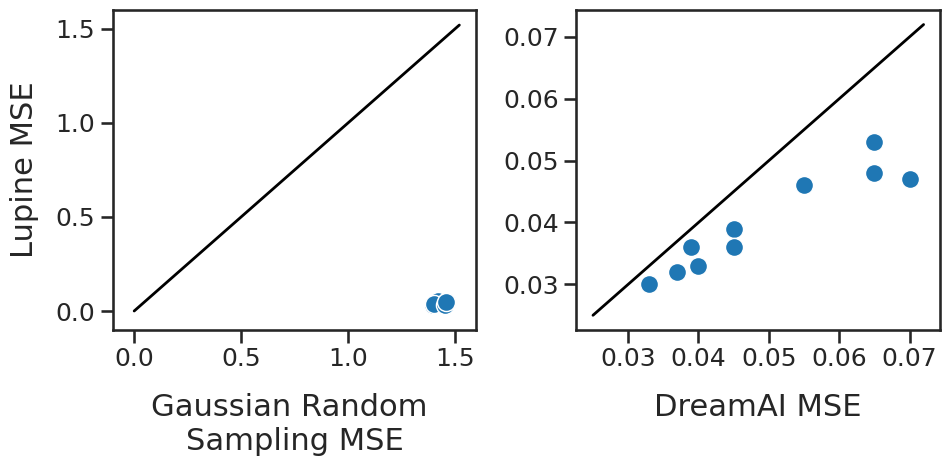

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

# LUPINE VS MEAN IMPUTE
sns.scatterplot(
    data=bench_res, 
    x="rand_draw_error", 
    y="lupine_error", 
    alpha=1.0, 
    zorder=2, 
    s=170,
    ax=ax1,
)
#ax1.set_title()
ax1.set_xlabel("Gaussian Random \nSampling MSE", labelpad=16, fontsize=22)
ax1.set_ylabel("Lupine MSE", labelpad=12, fontsize=22)

# Add diagonal line
ax1_min = 0.0
ax1_max = 1.52
x = np.linspace(ax1_min, ax1_max, 100)
y = x
ax1.plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

ax1.set_xlim(-0.1, 1.6)
ax1.set_ylim(-0.1, 1.6)

# LUPINE VS DREAM-AI
sns.scatterplot(
    data=bench_res,
    x="dream_error", 
    y="lupine_error", 
    alpha=1.0, 
    zorder=2, 
    s=170,
    ax=ax2
)
#ax2.set_title()
ax2.set_xlabel("DreamAI MSE", labelpad=16, fontsize=22)
ax2.set_ylabel("", labelpad=16, fontsize=22)

# Add diagonal line
ax2_min = 0.025
ax2_max = 0.072
x = np.linspace(ax2_min, ax2_max, 100)
y = x
ax2.plot(x, y, color="black", alpha=1.0, zorder=1, linewidth=2)

# ax1.minorticks_off()
# ax2.minorticks_off()

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)

#ax2.xaxis.set_ticks(np.arange(0.02, 0.10, 0.04))
#ax2.yaxis.set_ticks(np.arange(0.02, 0.10, 0.04))

ax2.locator_params(axis='x', nbins=6)
ax2.locator_params(axis='y', nbins=6)

fig.tight_layout()

#plt.show()
plt.savefig("../figures/mse-benchmarking-figure-v3.pdf", bbox_inches="tight")